In [1]:
import numpy as np
import cv2
from EstimateFundamentalMatrix import *
from GetInliersRANSAC import *
from EssentialMatrixFromFundamentalMatrix import *
from ExtractCameraPose import *
from LinearTriangulation import *
from DisambiguateCameraPose import *
from NonLinearTriangulation import *
from NonLinearPnP import *
from PnPRansac import *
from Utils.ImageUtils import *
from Utils.DataLoader import *
from matplotlib import pyplot as plt
import scipy
from recoverPose import *
K = np.array([[568.996140852, 0, 643.21055941],[0, 568.988362396, 477.982801038],[0, 0, 1]]).reshape(3,3)

In [2]:
import scipy.optimize as optimize
import tqdm as tqdm

In [7]:
folder_name = "../Data/"
total_images = 6
images = readImageSet(folder_name, total_images)
feature_matrix = extractMatchingFeaturesFromFile(folder_name, total_images)
# for n in range(0, total_images-1):
#     for m in range(n+1, total_images):
#         feature = np.array(feature_matrix[n,m]).reshape(-1,7)
#         matched_pairs = feature[:,3:7]
#         # print(matched_pairs)
#         showMatches(images[n], images[m], matched_pairs, (0, 255, 0), "Results/" + str(n) + str(m) + ".jpg")

filtered_feature_matrix = np.empty(shape=(total_images, total_images), dtype=object)
f_matrix = np.empty(shape=(total_images, total_images), dtype=object)
e_matrix = np.empty(shape=(total_images, total_images), dtype=object)
p_matrix = np.empty(shape=(total_images, total_images), dtype=object)

for i in range(total_images):
    for j in range(total_images):
        filtered_feature_matrix[i,j] = None
        f_matrix[i, j] = None
        e_matrix[i, j] = None
        p_matrix[i, j] = None

Reading images from  ../Data/


In [11]:
for n in range(0, total_images-1):
    for m in range(n+1, total_images):
        # print(feature_matrix[n, m])
        if feature_matrix[n, m] is not None:
            
            features = np.array(feature_matrix[n, m]).reshape(-1,7)
#             f, _ = cv2.findFundamentalMat(np.int32(features[:, 3:5]), np.int32(features[:, 5:7]),cv2.FM_LMEDS)
            # print(f)
            f = EstimateFundamentalMatrix(features)
            # print(">>>>>>>>", f/f[2,2])
            f_matrix[n, m] = f
            filtered_feature_matrix[n,m] = features
            if f is not None:
                f_better, filtered_features = getInliers(features, n_iterations = 2000, error_thresh = 0.0001)
                filtered_feature_matrix[n, m] = filtered_features
                print(n, m,': ', len(filtered_features), '/', len(features))
                f_matrix[n, m] = f_better
# essential matrix
for n in range(0, total_images):
    for m in range(0, total_images):
        if f_matrix[n, m] is not None:
            e_matrix[n, m] = getEssentialMatrix(K, f_matrix[n, m])
            
np.save('./tmp_files/e_matrix.npy', e_matrix)
np.save('./tmp_files/feature_matrix.npy', filtered_feature_matrix)

Reading images from  ../Data/
0 1 :  52 / 1426
0 2 :  34 / 608


KeyboardInterrupt: 

In [8]:
filtered_feature_matrix = np.load('./tmp_files/feature_matrix.npy', allow_pickle = True)
e_matrix = np.load('./tmp_files/e_matrix.npy', allow_pickle = True)

In [9]:
filtered_feature_matrix.shape

(6, 6)

In [10]:
#camera rot and trans
p_matrix = np.empty(shape=(total_images, total_images), dtype=object)
for n in range(0, total_images):
    for m in range(0, total_images):
        if e_matrix[n, m] is not None:
            p_matrix[n, m] = ExtractCameraPose(e_matrix[n, m])

In [11]:
C_matrix = np.empty(shape=(total_images, total_images), dtype=object)
R_matrix = np.empty(shape=(total_images, total_images), dtype=object)
X3D_matrix = np.empty(shape=(total_images, total_images), dtype=object)

for n in range(0, total_images):
    for m in range(0, total_images):
        if p_matrix[n,m] is not None:
            r_set, c_set = p_matrix[n,m]
            pts1, pts2 = filtered_feature_matrix[n,m][:, 3:5], filtered_feature_matrix[n,m][:, 5:7]
            x3D_set, _  = LinearTriangulation(r_set, c_set, pts1, pts2, K)
            R, C, x3D = DisambiguatePose(r_set, c_set, x3D_set)
#             R, C, x3D = recoverPose_cv2(e_matrix[n, m], pts1, pts2, K) # inbuilt function
            C_matrix[n,m] = C
            R_matrix[n,m] = R
            X3D_matrix[n,m] = x3D
            
            x_proj = projectPts(R, C, x3D, K)
            im = images[m].copy()
            for i in range(pts2.shape[0]):
                x1,y1,_ = x_proj[i]
#                 x3,y3,_ = x_proj_opt[i]
                x2,y2 = pts2[i]
                
#                 cv2.circle(im, (int(x3), int(y3)), 3, (255,0,0), 3)
                cv2.circle(im, (int(x1), int(y1)), 3, (0,0,255), -1) # reprojected
                cv2.circle(im, (int(x2), int(y2)), 3, (0,255,0), -1) # actual
            cv2.imshow("im" + str(n)+ str(m), im)
            cv2.waitKey() 
cv2.destroyAllWindows()             

# Non Linear Triangulation - works

In [12]:
x3D_optimized_matrix = np.empty(shape=(total_images, total_images), dtype=object)
reprojection_error1 = []
reprojection_error2 = []

for n in range(0, total_images):
    for m in range(0, total_images):
        if e_matrix[n, m] is not None:
            R1, C1 = np.identity(3), np.zeros((3,1))
            R2 = R_matrix[n,m] 
            C2 = C_matrix[n,m]
            x3D = X3D_matrix[n,m]
            pts1, pts2 = filtered_feature_matrix[n,m][:, 3:5], filtered_feature_matrix[n,m][:, 5:7]  
            x3D_optimized = NonLinearTriangulation(K, pts1, pts2, x3D, R1, C1, R2, C2)
            x3D_optimized_matrix[n,m] = x3D_optimized 
            mean_error1 = meanReprojectionError(x3D, pts1, pts2, R1, C1, R2, C2, K )
            mean_error2 = meanReprojectionError(x3D_optimized, pts1, pts2, R1, C1, R2, C2, K )
            reprojection_error1.append(mean_error1)
            reprojection_error2.append(mean_error2)
            print(n,m,':  Before Optimization: ', mean_error1,'After Optimization: ', mean_error2)
np.mean(reprojection_error1), np.mean(reprojection_error2)            


0 1 :  Before Optimization:  41.38931272613464 After Optimization:  40.98978964067746
0 2 :  Before Optimization:  94.69148963294157 After Optimization:  92.88568216275343
0 3 :  Before Optimization:  261.4542120784101 After Optimization:  236.79855078405532
1 2 :  Before Optimization:  1.8552149250932604 After Optimization:  1.8378322387701496
1 3 :  Before Optimization:  20.8506763017668 After Optimization:  20.20519361217968
2 3 :  Before Optimization:  0.4039090358606036 After Optimization:  0.4011000514903215
2 4 :  Before Optimization:  61.30183508151159 After Optimization:  60.97252465464124
2 5 :  Before Optimization:  73.21237873950216 After Optimization:  71.14018608864481
3 4 :  Before Optimization:  28.69896214336119 After Optimization:  28.32802972454471
3 5 :  Before Optimization:  25.905708121750248 After Optimization:  25.827058198996905
4 5 :  Before Optimization:  18.441559088157717 After Optimization:  18.287972230350114


(57.1095688976809, 54.33399267155493)

In [23]:
np.save('./tmp_files/R_matrix.npy', R_matrix)
np.save('./tmp_files/C_matrix.npy', C_matrix)
np.save('./tmp_files/x3D_optimized_matrix.npy', x3D_optimized_matrix)
np.save('./tmp_files/X3D_matrix.npy', X3D_matrix)

In [14]:
R_matrix = np.load('./tmp_files/R_matrix.npy', allow_pickle = True)
C_matrix = np.load('./tmp_files/C_matrix.npy', allow_pickle = True)
x3D_optimized_matrix = np.load('./tmp_files/x3D_optimized_matrix.npy', allow_pickle = True)
# x3D_matrix = np.load('./tmp_files/x3D_matrix.npy', allow_pickle = True)

# Linear PnP - Unit Test

# PNPRansac Unit Test

In [47]:
## run once
n,m = 0,1
R1, C1 = np.identity(3), np.zeros((3,1))
R2 = R_matrix[n,m] 
C2 = C_matrix[n,m]
x3D = x3D_optimized_matrix[n,m]
pts1, pts2 = filtered_feature_matrix[n,m][:, 3:5], filtered_feature_matrix[n,m][:, 5:7]

In [30]:
R,C = PnPRANSAC(pts2, x3D, n_iterations = 1000, error_thresh = 5)

In [21]:
## run for all
C_matrix_pnp = np.empty(shape=(total_images, total_images), dtype=object)
R_matrix_pnp = np.empty(shape=(total_images, total_images), dtype=object)

reprojection_error1 = []
reprojection_error2 = []

for n in range(0, total_images):
    for m in range(0, total_images):
        if e_matrix[n, m] is not None:
            R1, C1 = np.identity(3), np.zeros((3,1))
            R2 = R_matrix[n,m] 
            C2 = C_matrix[n,m]
            x3D = X3D_optimized_matrix[n,m]
            pts1, pts2 = filtered_feature_matrix[n,m][:, 3:5], filtered_feature_matrix[n,m][:, 5:7]
            R, C = PnPRANSAC(K, pts2, x3D, n_iterations = 1000, error_thresh = 5)
            R_matrix_pnp[n,m]  = R
            C_matrix_pnp[n,m]  = C
            
#             R, C = PnPRANSAC_(x3D, pts2, K)
            mean_error1 = meanReprojectionError(x3D, pts1, pts2, R1, C1, R2, C2, K )
            mean_error2 = meanReprojectionError(x3D, pts1, pts2, R1, C1, R, C, K )
            reprojection_error1.append(mean_error1)
            reprojection_error2.append(mean_error2)
            print(n,m,':  Before Optimization: ', mean_error1,'After Optimization: ', mean_error2)
np.mean(reprojection_error1), np.mean(reprojection_error2)            

0 1 :  Before Optimization:  41.38931272613464 After Optimization:  135.9560681234535
0 2 :  Before Optimization:  94.69148963294157 After Optimization:  1002.5560537089642
0 3 :  Before Optimization:  261.4542120784101 After Optimization:  3136.269768696359
1 2 :  Before Optimization:  1.8552149250932604 After Optimization:  436.262693768403
1 3 :  Before Optimization:  20.8506763017668 After Optimization:  2574.860325896211
2 3 :  Before Optimization:  0.4039090358606036 After Optimization:  675.3380450220143
2 4 :  Before Optimization:  61.30183508151159 After Optimization:  1294.5486085705127
2 5 :  Before Optimization:  73.21237873950216 After Optimization:  5254.796808157788
3 4 :  Before Optimization:  28.69896214336119 After Optimization:  293.2133468324653
3 5 :  Before Optimization:  25.905708121750248 After Optimization:  2638.3776544982325
4 5 :  Before Optimization:  18.441559088157717 After Optimization:  330.6101189796079


(57.1095688976809, 1615.7081356594551)

# Non Linear PnP

In [40]:
from scipy.spatial.transform import Rotation 

def getQuaternion(R2):
    Q = Rotation.from_matrix(R2)
    return Q.as_quat()

def getRotation(Q):
    R = Rotation.from_quat(Q)
    return R.as_matrix()

def homo(pts):
    return np.hstack((pts, np.ones((pts.shape[0], 1))))

def ProjectionMatrix(K,R,C):
    I  = np.identity(3)
    return np.dot(K, np.dot(R, np.hstack((I, -C))))


def NonLinearPnP(K, pts1, pts2, x3D, R2, C2):
    """    
    K : Camera Matrix
    pts1, pts2 : Point Correspondences
    x3D :  initial 3D point 
    R2, C2 : relative camera pose - estimated from PnP

    Returns:
        x3D : optimized 3D points
    """
    if pts1.shape[0] != pts2.shape[0] != x3D.shape[0]:
        raise 'Check point dimensions - level nlt'
    
    Q = getQuaternion(R2)
    X0 = [Q[0] ,Q[1],Q[2],Q[3], C2[0], C2[1], C2[2]] 

    optimized_params = optimize.least_squares(
        fun = PnPLoss,
        x0=X0,
        method="trf",
        args=[x3D, pts1, pts2, K])
    X1 = optimized_params.x
    Q = X1[:4]
    C = X1[4:]
    R = getRotation(Q)
    return R, C


def PnPLoss(X0, x3D, pts1, pts2, K):
    
    Q, C2 = X0[:4], X0[4:].reshape(-1,1)
    R2 = getRotation(Q)
    R1, C1 = np.identity(3), np.zeros((3,1))
    P1 = ProjectionMatrix(K,R1,C1) 
    P2 = ProjectionMatrix(K,R2,C2)
    
    Error = []
    for X, pt1, pt2 in zip(x3D, pts1, pts2):

        p1_1T, p1_2T, p1_3T = P1 # rows of P1
        p1_1T, p1_2T, p1_3T = p1_1T.reshape(1,-1), p1_2T.reshape(1,-1),p1_3T.reshape(1,-1)

        p2_1T, p2_2T, p2_3T = P2 # rows of P2
        p2_1T, p2_2T, p2_3T = p2_1T.reshape(1,-1), p2_2T.reshape(1,-1), p2_3T.reshape(1,-1)

        X = homo(X.reshape(1,-1)).reshape(-1,1) # make X it a column of homogenous vector
        ## reprojection error for reference camera points - j = 1
        u1,v1 = pt1[0], pt1[1]
        u1_proj = np.divide(p1_1T.dot(X) , p1_3T.dot(X))
        v1_proj =  np.divide(p1_2T.dot(X) , p1_3T.dot(X))
        E1= np.square(v1 - v1_proj) + np.square(u1 - u1_proj)


        ## reprojection error for second camera points - j = 2    
        u2,v2 = pt2[0], pt2[1]
        u2_proj = np.divide(p2_1T.dot(X) , p2_3T.dot(X))
        v2_proj =  np.divide(p2_2T.dot(X) , p2_3T.dot(X))

        E2= np.square(v2 - v2_proj) + np.square(u2 - u2_proj)
        error = E1 + E2
        Error.append(error)
        
#     meanError = np.mean(np.array(Error).squeeze())
#     return meanError
    sumError = np.mean(np.array(Error).squeeze())
    return sumError

array([[ 0.98168708,  0.04088804, -0.18606089],
       [-0.0065019 ,  0.98331683,  0.18178488],
       [ 0.19038963, -0.17724612,  0.96557527]])

In [53]:
## run once
n,m = 0,1
R1, C1 = np.identity(3), np.zeros((3,1))
R2 = R_matrix_pnp[n,m] 
C2 = C_matrix_pnp[n,m]
x3D = x3D_optimized_matrix[n,m]
pts1, pts2 = filtered_feature_matrix[n,m][:, 3:5], filtered_feature_matrix[n,m][:, 5:7]

R,C = NonLinearPnP(K, pts1, pts2, x3D, R2, C2)


KeyboardInterrupt: 

In [55]:
C_optimized_matrix = np.empty(shape=(total_images, total_images), dtype=object)
R_optimized_matrix = np.empty(shape=(total_images, total_images), dtype=object)

reprojection_error1 = []
reprojection_error2 = []
for n in range(0, total_images):
    for m in range(0, total_images):
        if e_matrix[n, m] is not None:
#             R1, C1 = np.identity(3), np.zeros((3,1))
            R2 = R_matrix_pnp[n,m] 
            C2 = C_matrix_pnp[n,m]
            x3D = X3D_matrix[n,m]
            pts1, pts2 = filtered_feature_matrix[n,m][:, 3:5], filtered_feature_matrix[n,m][:, 5:7]
            R, C = NonLinearPnP(K, pts1, pts2, x3D, R2, C2)
            R_optimized_matrix[n,m]  = R
            C_optimized_matrix[n,m]  = C
            
            mean_error1 = meanReprojectionError(x3D, pts1, pts2, R1, C1, R2, C2, K )
            mean_error2 = meanReprojectionError(x3D, pts1, pts2, R1, C1, R, C, K )
            reprojection_error1.append(mean_error1)
            reprojection_error2.append(mean_error2)
            print(n,m,':  Before Optimization: ', mean_error1,'After Optimization: ', mean_error2)
np.mean(reprojection_error1), np.mean(reprojection_error2)            

0 1 :  Before Optimization:  135.9560681234535 After Optimization:  96.72880061779098
0 2 :  Before Optimization:  1002.5560537089642 After Optimization:  133.93380573706014
0 3 :  Before Optimization:  3136.269768696359 After Optimization:  217.00614645073944
1 2 :  Before Optimization:  436.262693768403 After Optimization:  69.53496186774645
1 3 :  Before Optimization:  2574.860325896211 After Optimization:  23.117391577622875
2 3 :  Before Optimization:  675.3380450220143 After Optimization:  59.89086863946088
2 4 :  Before Optimization:  1294.5486085705127 After Optimization:  51.98708475540126
2 5 :  Before Optimization:  5254.796808157788 After Optimization:  42.420077514231615
3 4 :  Before Optimization:  293.2133468324653 After Optimization:  94.84860091080782
3 5 :  Before Optimization:  2638.3776544982325 After Optimization:  23.483794174788617
4 5 :  Before Optimization:  330.6101189796079 After Optimization:  151.6422227995114


(836.4088522785681, 851.6992385135989)

In [56]:
np.save('./tmp_files/R_matrix_pnp.npy', R_matrix_pnp)
np.save('./tmp_files/C_matrix_pnp.npy', C_matrix_pnp)
np.save('./tmp_files/R_optimized_matrix.npy', R_optimized_matrix)
np.save('./tmp_files/C_optimized_matrix.npy', C_optimized_matrix)

#  Printing All three points

In [59]:

for n in range(0, total_images):
    for m in range(0, total_images):
        if R_matrix[n,m] is not None:
            pts1, pts2 = filtered_feature_matrix[n,m][:, 3:5], filtered_feature_matrix[n,m][:, 5:7]
            C = C_optimized_matrix[n,m]
            R = R_optimized_matrix[n,m]
            x3D = x3D_optimized_matrix[n,m]
            x_proj_opt = projectPts(R, C, x3D, K)
            
            C2 = C_matrix[n,m]
            R2 = R_matrix[n,m]
            x_proj = projectPts(R2, C2, x3D, K)
            
            im = images[m].copy()
            for i in range(pts2.shape[0]):
                x1,y1,_ = x_proj[i]
                x3,y3,_ = x_proj_opt[i]
                x2,y2 = pts2[i]
                
                cv2.circle(im, (int(x3), int(y3)), 3, (255,0,0), -1)
                cv2.circle(im, (int(x1), int(y1)), 3, (0,0,255), -1) # reprojected
                cv2.circle(im, (int(x2), int(y2)), 3, (0,255,0), -1) # actual
            cv2.imshow("im" + str(n)+ str(m), im)
            cv2.waitKey() 
cv2.destroyAllWindows()         

## Visualize matches

In [4]:
for n in range(0, total_images-1):
    for m in range(n+1, total_images):
        if feature_matrix[n,m] is not None:
            feature = np.array(filtered_feature_matrix[n,m]).reshape(-1,7)
            matched_pairs = feature[:,3:7]
        else:
            matched_pairs = None

        if filtered_feature_matrix[n,m] is not None:
            filtered_feature = np.array(filtered_feature_matrix[n,m]).reshape(-1,7)
            filtered_matched_pairs = filtered_feature[:,3:7]
        else:
            filtered_matched_pairs = None

        showMatches(images[n], images[m], matched_pairs, (0, 255, 0), None)
        showMatches(images[n], images[m], filtered_matched_pairs, (0, 0, 255),"../Results/" + str(n) + str(m) + ".jpg")

## Get 3D points

In [5]:
# R2_, C2_ = p_matrix[1,2]
# matched_pairs = filtered_feature_matrix[1,2]
l = 4
p = 5
R2_, C2_ = p_matrix[l,p]
matched_pairs = filtered_feature_matrix[l,p]
R1_ = np.identity(3)
C1_ = np.zeros((3,1))
I = np.identity(3)
# P1 = np.dot(K, np.dot(R1_, np.hstack((I, -C1_))))
P1 = np.dot(K, np.hstack((R1_, C1_)))


pts3D_4 = []
for i in range(len(C2_)):
    pts3D = []
    x1 = matched_pairs[:,3:5]
    x2 = matched_pairs[:,5:7]
    # x1 = matched_pairs[:,3:5].T
    # x2 = matched_pairs[:,5:7].T

    P2 = np.dot(K, np.dot(R2_[i], np.hstack((I, -C2_[i].reshape(3,1)))))
    #P2 = np.dot(K, np.hstack((R2_[i], C2_[i].reshape(3,1))))

    # X = cv2.triangulatePoints(P1, P2, x1, x2)  
    X = LinearTriangulation(K, C1_, R1_, C2_[i], R2_[i], x1, x2)
    # X = X/X[3,:]
    pts3D_4.append(X)


## Reproject 3D points to 2D

In [9]:
k = 0
P2 = np.dot(K, np.dot(R2_[k], np.hstack((I, -C2_[k].reshape(3,1)))))

# P2 = np.dot(K, np.hstack((R2_[k], C2_[k].reshape(3,1))))
X01 = pts3D_4[k]
x01 = np.dot(P2, X01.T)
x01 = x01/x01[2,:]

x = x01[0, :].T
y = x01[1, :].T

im = images[p].copy()
filtered_feature = matched_pairs
for i in range(filtered_feature.shape[0]):

    x1, y1 = x[i], y[i]
    x2, y2 = filtered_feature[i, 5], filtered_feature[i, 6]
    cv2.circle(im, (int(x1), int(y1)), 3, (0,0,255), 3)
    cv2.circle(im, (int(x2), int(y2)), 3, (0,255,0), 3)

cv2.imshow("im", im)
cv2.waitKey() 
cv2.destroyAllWindows()

## Plot 3D points

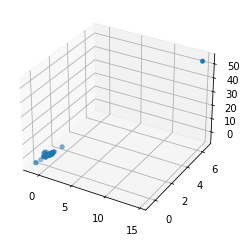

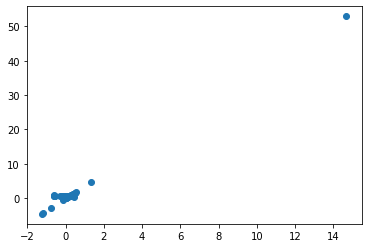

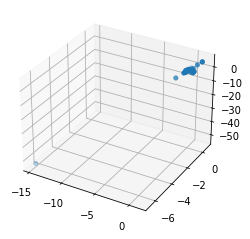

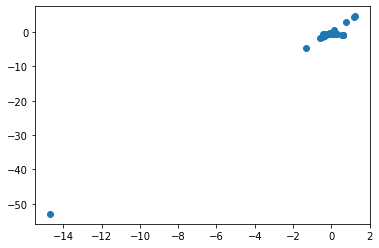

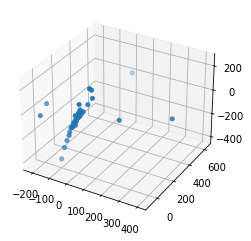

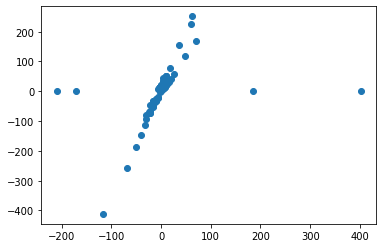

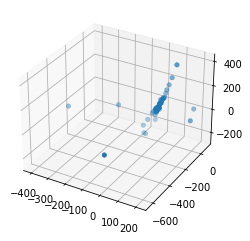

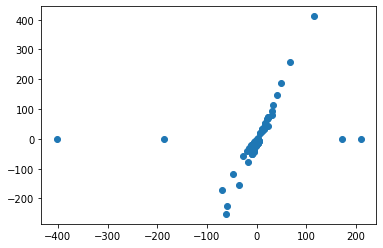

In [8]:
for i in range(len(pts3D_4)):
    # print(pts3D.shape)

    pts3D = pts3D_4[i]
    # X = X/X[3,:]

    pts3D = pts3D/pts3D[:,3].reshape(-1,1)
    x = pts3D[:,0]
    x[(x > 500) | (x < -500)] = 0
    y = pts3D[:,1]
    # y[(y > 500) | (y < -500)] = 0
    # plt.scatter(x, y, linewidths = 0.1)
    z = pts3D[:,2]
    z[(z > 500) | (z < -500)] = 0 


    fig = plt.figure()
#     for n in range(0, total_images):
#     for m in range(0, total_images):
#         if f_matrix[n, m] is not None:
#             e_matrix[n, m] = getEssentialMatrix(K, f_matrix[n, m])

# for n in range(0, total_images):
#     for m in range(0, total_images):
#         if e_matrix[n, m] is not None:
#             p_matrix[n, m] = ExtractCameraPose(e_matrix[n, m])
    ax = plt.axes(projection='3d')
    ax.scatter(x,y, z, linewidth=0.5)

    fig = plt.figure()
    plt.scatter(x,z)



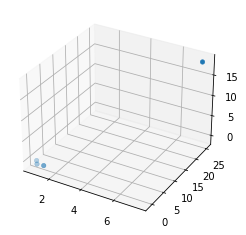

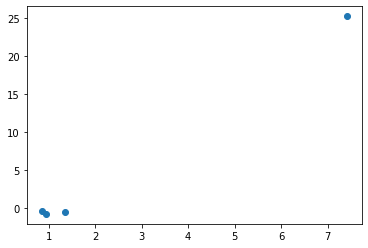

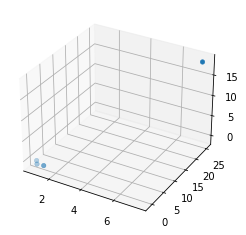

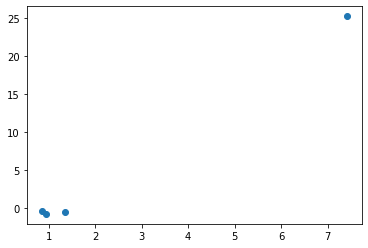

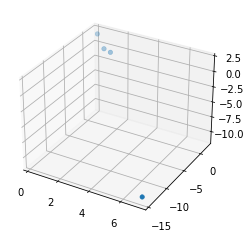

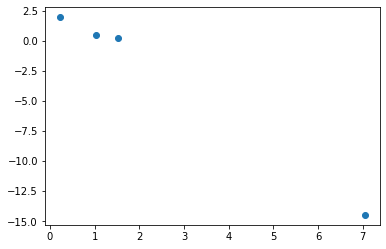

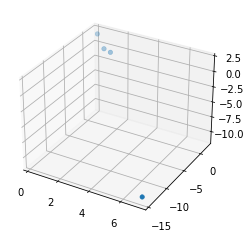

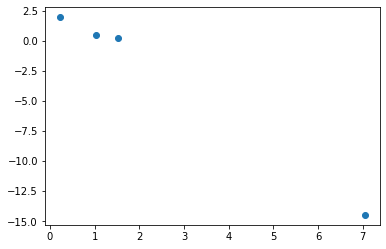

In [46]:
# for i in range(len(pts3D_4)):
#     # print(pts3D.shape)

#     pts3D = pts3D_4[i]
#     # X = X/X[3,:]

#     pts3D = pts3D/pts3D[3,:]
#     x = pts3D[0,:]
#     x[(x > 500) | (x < -500)] = 0
#     y = pts3D[1,:]
#     # y[(y > 500) | (y < -500)] = 0
#     # plt.scatter(x, y, linewidths = 0.1)
#     z = pts3D[2,:]
#     z[(z > 500) | (z < -500)] = 0 


#     fig = plt.figure()
#     ax = plt.axes(projection='3d')
#     ax.scatter(x,z,y, linewidth=0.5)

#     fig = plt.figure()
#     plt.scatter(x,z)



In [43]:
np.max(pts3D_4[0], axis = 0)

array([  7.07828079, 103.07042896, 581.84002598])

In [8]:
np.dot(S, R2), E

(array([[-0.01436469, -0.67238415, -0.25949168],
        [ 0.84380403, -0.06920706,  0.51278222],
        [ 0.15586874, -0.67339079, -0.15121706]]),
 array([[ 0.01436469,  0.67238415,  0.25949168],
        [-0.84380403,  0.06920706, -0.51278222],
        [-0.15586874,  0.67339079,  0.15121706]]))

In [23]:
f_matrix[0,1]

array([[-1.88698770e-07, -9.76264840e-06,  2.87810342e-03],
       [ 1.16489905e-05, -6.00183951e-07, -4.14682120e-03],
       [-4.48090117e-03,  2.29982535e-03,  1.00000000e+00]])